Dodatno: \\
4') (do 8 bodova) Napisati funkciju koja učitava dve fotografije i od njih pravi panoramu. Korisnik identifikuje određen broj  (>= 4) tačaka  koje su "iste" na obe fotografije i na osnovu toga se računa projektivno preslikavanje koje "lepi" fotografije. Alternativno, može se koristiti SIFT biblioteka za odredjivanje tačaka. Implementacija RANSAC algoritma, ko želi.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def draw(src_p, dst_p):
    xs = [p[0] for p in src_p]
    ys = [p[1] for p in src_p]
    xs.append(src_p[0][0])
    ys.append(src_p[0][1])

    xd = [p[0] for p in dst_p]
    yd = [p[1] for p in dst_p]
    xd.append(dst_p[0][0])
    yd.append(dst_p[0][1])

    plt.plot(xs, ys)
    plt.plot(xd, yd)
    plt.legend(['original', 'slika'])
    plt.show()

In [ ]:
# originalne tacke
src_points = [[1, 1, 1],
              [5, 2, 1],
              [6, 4, 1],
              [-1, 7, 1]]

# slike tacaka
dst_points = [[0, 0, 1],
              [10, 0, 1],
              [10, 5, 1],
              [0, 5, 1]]

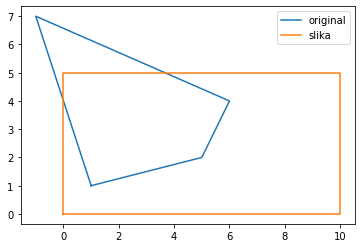

In [ ]:
# Graficki prikaz
draw(src_points, dst_points)

***1. NAIVNI ALGORITAM***

In [ ]:
def find_matrix(pts):
    matrix = np.array([ # A, B, C
        [pts[0][0], pts[1][0], pts[2][0]],
        [pts[0][1], pts[1][1], pts[2][1]],
        [pts[0][2], pts[1][2], pts[2][2]]
    ])

    D = np.array([pts[3][0], pts[3][1], pts[3][2]])

    # D = alpha*A + beta*B + gamma*C
    result = np.linalg.solve(matrix, D)

    alpha = result[0]
    beta = result[1]
    gamma = result[2]

    column1= np.array([alpha*pts[0][0], alpha*pts[0][1], alpha*pts[0][2]])
    column2= np.array([beta*pts[1][0], beta*pts[1][1], beta*pts[1][2]])
    column3= np.array([gamma*pts[2][0], gamma*pts[2][1], gamma*pts[2][2]])

    P = np.column_stack([column1, column2, column3])

    return P

def naive_algorithm(src_p, dst_p):

    P1 = find_matrix(src_p)
    P2 = find_matrix(dst_p)

    # P = P2*inv(P1)
    P = np.dot(P2, np.linalg.inv(P1))

    return P

In [ ]:
# Matrica projektivnog preslikavanja
P_naive = naive_algorithm(src_points, dst_points)
P_naive = P_naive.round(5)
print(P_naive)

[[ 0.44872  0.14957 -0.59829]
 [-0.19231  0.76923 -0.57692]
 [-0.07278  0.07378  0.41076]]


In [ ]:
# Za DLT i modifikovani DLT (vise od 4 korespodencije)

# originalne tacke
src_points = [[-3, -1, 1],
              [3, -1, 1],
              [1, 1, 1],
              [-1, 1, 1],
              [1, 2, 3],
              [-8, -2, 1]]

# slike tacaka
dst_points = [[-2, -1, 1],
              [2, -1, 1],
              [2, 1, 1],
              [-2, 1, 1],
              [2, 1, 4],
              [-16, -5, 4]]

In [ ]:
# draw(src_points, dst_points)

***2. DLT ALGORITAM***

In [ ]:
def dlt(src_p, dst_p):
    x = src_p[0][0]
    y = src_p[0][1]
    z = src_p[0][2]

    u = dst_p[0][0]
    v = dst_p[0][1]
    w = dst_p[0][2]

    A = np.array([
        [0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z],
        [w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z]
    ])

    for i in range(1, len(src_p)):
        x = src_p[i][0]
        y = src_p[i][1]
        z = src_p[i][2]

        u = dst_p[i][0]
        v = dst_p[i][1]
        w = dst_p[i][2]

        row1 = np.array([0, 0, 0, -w*x, -w*y, -w*z, v*x, v*y, v*z])
        row2 = np.array([w*x, w*y, w*z, 0, 0, 0, -u*x, -u*y, -u*z])

        A = np.vstack((A, row1))
        A = np.vstack((A, row2))

    # print(A.shape)
    # print(A)

    # SVD dekompozicija
    U, S, V = np.linalg.svd(A)

    P = V[-1].reshape(3,3)
    
    return P

In [ ]:
P_dlt = dlt(src_points, dst_points)
print(P_dlt.round(5))

[[ 0.34188  0.11396 -0.45584]
 [-0.14652  0.58608 -0.43956]
 [-0.05545  0.05621  0.31296]]


***Poredjenje DLT i naivnog algoritma***

In [ ]:
P_dlt = (P_dlt / P_dlt[0, 0]) * P_naive[0,0]
print(P_dlt.round(5))

[[ 0.44872  0.14957 -0.59829]
 [-0.19231  0.76923 -0.57693]
 [-0.07278  0.07378  0.41076]]


In [ ]:
P_dlt.round(5) == P_naive.round(5)

array([[ True,  True,  True],
       [ True,  True, False],
       [ True,  True,  True]])

***3. MODIFIKOVANI DLT ALGORITAM***

In [ ]:
import math

In [ ]:
def normalization(src_p):
    
    # teziste sistema tacaka C(x, y)
    x = sum([p[0]/p[2] for p in src_p]) / len(src_p)
    y = sum([p[1]/p[2] for p in src_p]) / len(src_p)
    
    # srednje rastojanje
    r = 0.0

    for i in range(len(src_p)):
        # translacija u koordinatni pocetak
        tmp1 = float(src_p[i][0]/src_p[i][2]) - x
        tmp2 = float(src_p[i][1]/src_p[i][2]) - y

        r = r + math.sqrt(tmp1**2 + tmp2**2)

    r = r / float(len(src_p))

    # skaliranje
    S = float(math.sqrt(2)) / r

    # vracamo matricu normalizacije 
    return np.array([[S, 0, -S*x], [0, S, -S*y], [0, 0, 1]])

def dlt_normalized(src_p, dst_p):

    # transformacije
    T = normalization(src_p)
    T_prim = normalization(dst_p)

    # normalizovane tacke
    M_line = T.dot(np.transpose(src_p))
    M_prim = T_prim.dot(np.transpose(dst_p))

    M_line = np.transpose(M_line)
    M_prim = np.transpose(M_prim)

    P_line = dlt(M_line, M_prim)

    P = (np.linalg.inv(T_prim)).dot(P_line).dot(T)

    return P

In [ ]:
P_dlt_norm = dlt_normalized(src_points, dst_points)
print(P_dlt_norm.round(5))

[[ 0.49851  0.16617 -0.66469]
 [-0.21365  0.8546  -0.64095]
 [-0.08085  0.08197  0.45634]]


***Poredjenje DLT i modifikovanog DLT algoritma***

In [ ]:
P_dlt_norm = (P_dlt_norm / P_dlt_norm[0, 0]) * P_dlt[0,0]
print(P_dlt_norm.round(5))

[[ 0.44872  0.14957 -0.59829]
 [-0.19231  0.76923 -0.57693]
 [-0.07278  0.07378  0.41076]]


In [ ]:
P_dlt_norm.round(5) == P_dlt.round(5)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

***4. UKLANJANJE PROJEKTIVNE DISTORZIJE***

In [81]:
from PIL import Image

In [87]:
img = Image.open('building.jpeg')
img_copy = Image.new('RGB', (img.size[0], img.size[1]), 'black')         

In [89]:
def change_photo(src_p, dst_p):
    # P = naive_algorithm(src_p, dst_p)
    # P = dlt(src_p, dst_p)
    P = dlt_normalized(src_p, dst_p)

    P = np.linalg.inv(P)
    cols = img_copy.size[0]
    rows = img_copy.size[1]

    for i in range(cols):        
        for j in range(rows):      
            new_coord = P.dot([i, j, 1]) 
            new_coord = [(x / new_coord[2]) for x in new_coord]
            
            if (new_coord[0] >= 0 and new_coord[0] < cols-1 and new_coord[1] >= 0 and new_coord[1] < rows-1):
                tmp1 = img.getpixel((math.floor(new_coord[0]), math.floor(new_coord[1])))
                tmp2 = img.getpixel((math.ceil(new_coord[0]), math.ceil(new_coord[1])))
                img_copy.putpixel((i, j), tmp2)
        

    fig = plt.figure(figsize=(16, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Pocetna slika:')

    plt.subplot(1, 2, 2)
    plt.imshow(img_copy)
    plt.title('Uklanjanje distorzije:')

    plt.tight_layout()
    plt.show()

Uneti afine koordinate 4 temena pravougaonika:
x koordinata: 164
y koordinata: 717
x koordinata: 294
y koordinata: 717
x koordinata: 294
y koordinata: 30
x koordinata: 164
y koordinata: 30


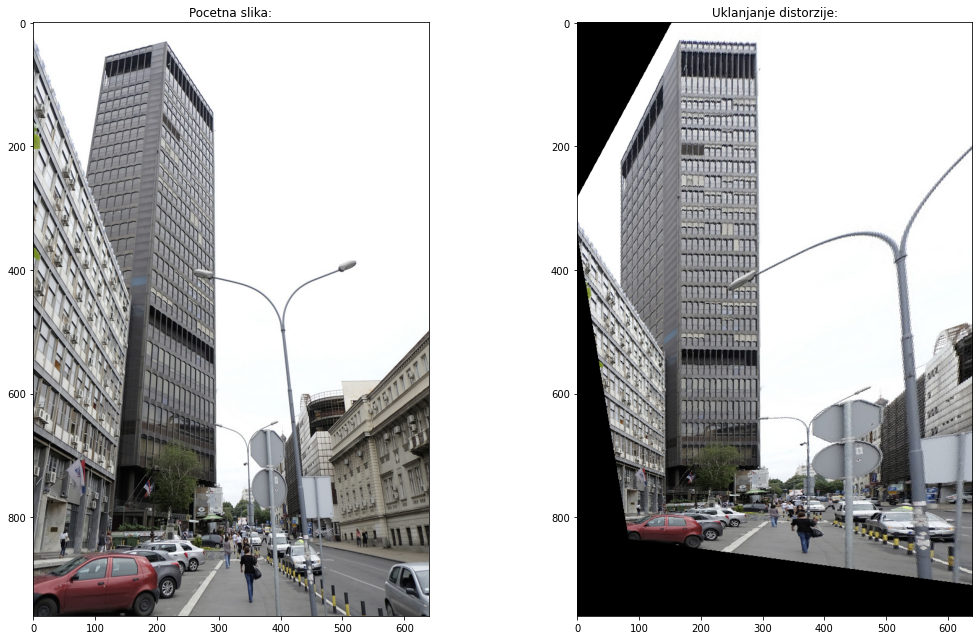

In [90]:
# tacke sa originalne slike (building.jpeg)
src_points = [[164, 717, 1],
              [294, 744, 1],
              [293, 147, 1],
              [214, 30, 1]]  

# primer ulaza za ovu sliku:
# dst_points = [[164, 717, 1],
#               [294, 717, 1],
#               [294, 30, 1],
#               [164, 30, 1]] 

dst_points = [[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0], 
              [0, 0, 0]]

print("Uneti afine koordinate 4 temena pravougaonika:")
for i in range(4):
    dst_points[i][0] = float(input("x koordinata: "))
    dst_points[i][1] = float(input("y koordinata: "))
    dst_points[i][2] = 1

change_photo(src_points, dst_points)